In [6]:
# import libaries
import duckdb
import pandas as pd
from datetime import datetime
from sodapy import Socrata
import os
import folium
from folium.plugins import MarkerCluster
from IPython.display import IFrame
from selenium import webdriver
import time

In [7]:
# data retrieved
current_date = datetime.now()
print(f"The data was retrieved on {current_date.strftime('%Y-%m-%d')}.")

The data was retrieved on 2025-04-21.


In [8]:
# nyc open data domain and 311 dataset id
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

# Socrata object to fetch data
client = Socrata(
    domain=socrata_domain,
    app_token=None,
    timeout=1000
)

# sanity check
print(client)

In [9]:
# query
query = """
    SELECT *
    WHERE descriptor == 'Street Flooding (SJ)' AND created_date between '2021-09-01T12:00:00' and '2021-09-04T12:00:00'
    LIMIT 100000 -- manually make this a high number, much above the results
"""

# get data from client
results = client.get(socrata_dataset_identifier, query=query)

# transform into dataframe
results_df = pd.DataFrame(results)

# close client
client.close()

print(f'shape of data: {results_df.shape}')
results_df.head()

shape of data: (759, 30)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2
0,51716489,2021-09-02T01:55:00.000,2021-09-06T12:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10302,17 BAYONNE COURT,BAYONNE COURT,...,944950,171782,ONLINE,Unspecified,STATEN ISLAND,40.63809131720773,-74.14160213232678,"{'latitude': '40.63809131720773', 'longitude':...",NaN,NaN
1,51716416,2021-09-02T21:41:00.000,2021-09-04T06:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11228,8414 15 AVENUE,15 AVENUE,...,981867,162359,ONLINE,Unspecified,BROOKLYN,40.6123140245488,-74.00858288641275,"{'latitude': '40.6123140245488', 'longitude': ...",NaN,NaN
2,51718574,2021-09-02T12:43:00.000,2021-09-05T08:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11228,1404 86 STREET,86 STREET,...,981048,162469,ONLINE,Unspecified,BROOKLYN,40.61261569377124,-74.01153274298028,"{'latitude': '40.61261569377124', 'longitude':...",NaN,NaN
3,51718575,2021-09-02T12:08:00.000,2021-09-06T17:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304,37 METCALFE STREET,METCALFE STREET,...,960468,163762,ONLINE,Unspecified,STATEN ISLAND,40.61613337335125,-74.08566089629163,"{'latitude': '40.61613337335125', 'longitude':...",NaN,NaN
4,51718713,2021-09-02T23:13:00.000,2021-09-07T17:35:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10464,401 HUNTER AVENUE,HUNTER AVENUE,...,1042769,248887,ONLINE,Unspecified,BRONX,40.84961841367458,-73.78847912076893,"{'latitude': '40.84961841367458', 'longitude':...",NaN,NaN


In [10]:
# Convert to numeric (float), set errors='coerce' to handle any bad data
results_df['latitude'] = pd.to_numeric(results_df['latitude'], errors='coerce')
results_df['longitude'] = pd.to_numeric(results_df['longitude'], errors='coerce')

# Drop rows with invalid or missing coordinates
results_df = results_df.dropna(subset=['latitude', 'longitude'])


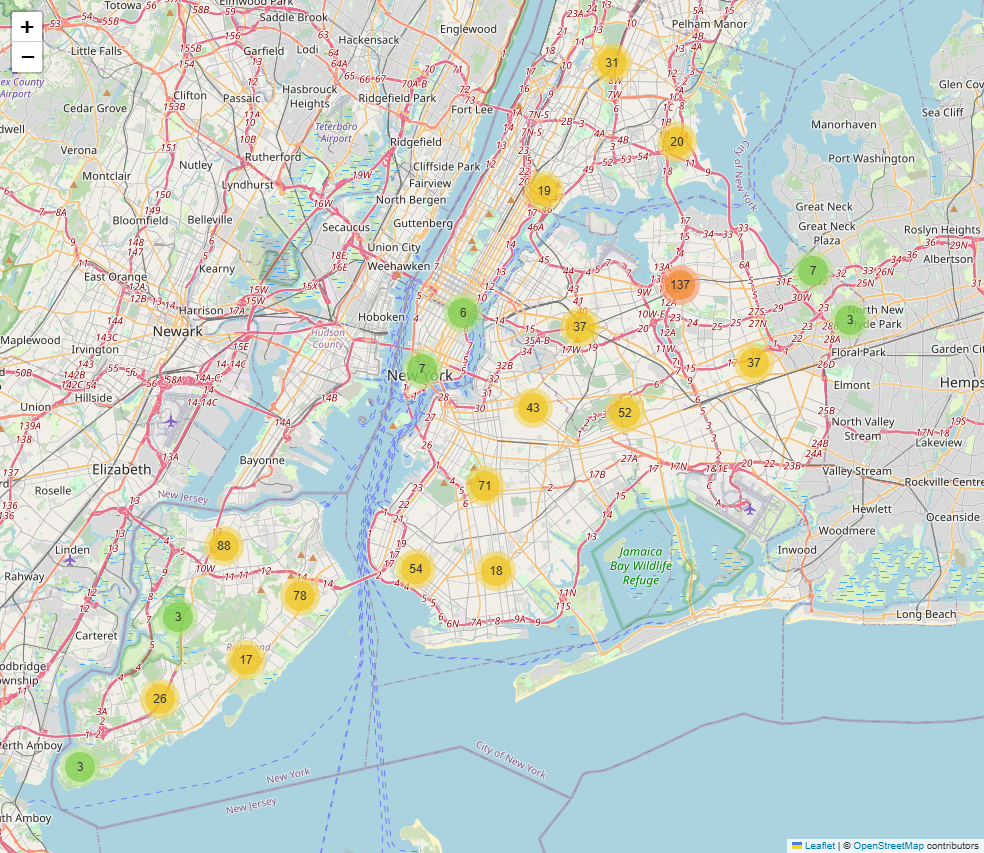

In [12]:
# Create the map around the mean of the latitude and longitude
m = folium.Map(location=[results_df['latitude'].mean(), results_df['longitude'].mean()])

# Initialize MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Loop through rows and add each point to the cluster
for _, row in results_df.iterrows():  # <-- changed from df to results_df  
    folium.Marker(
        location=[row['latitude'], row['longitude']]
    ).add_to(marker_cluster)

# Display the map (for GitHub)
cluster_map = "cluster_map.html"

options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

driver.set_window_size(1000, 1000)
driver.get("file://" + os.path.abspath("cluster_map.html"))
time.sleep(3)  # let map tiles load

driver.save_screenshot("clustermap_screenshot.png")
driver.quit()

from IPython.display import Image
Image("clustermap_screenshot.png")


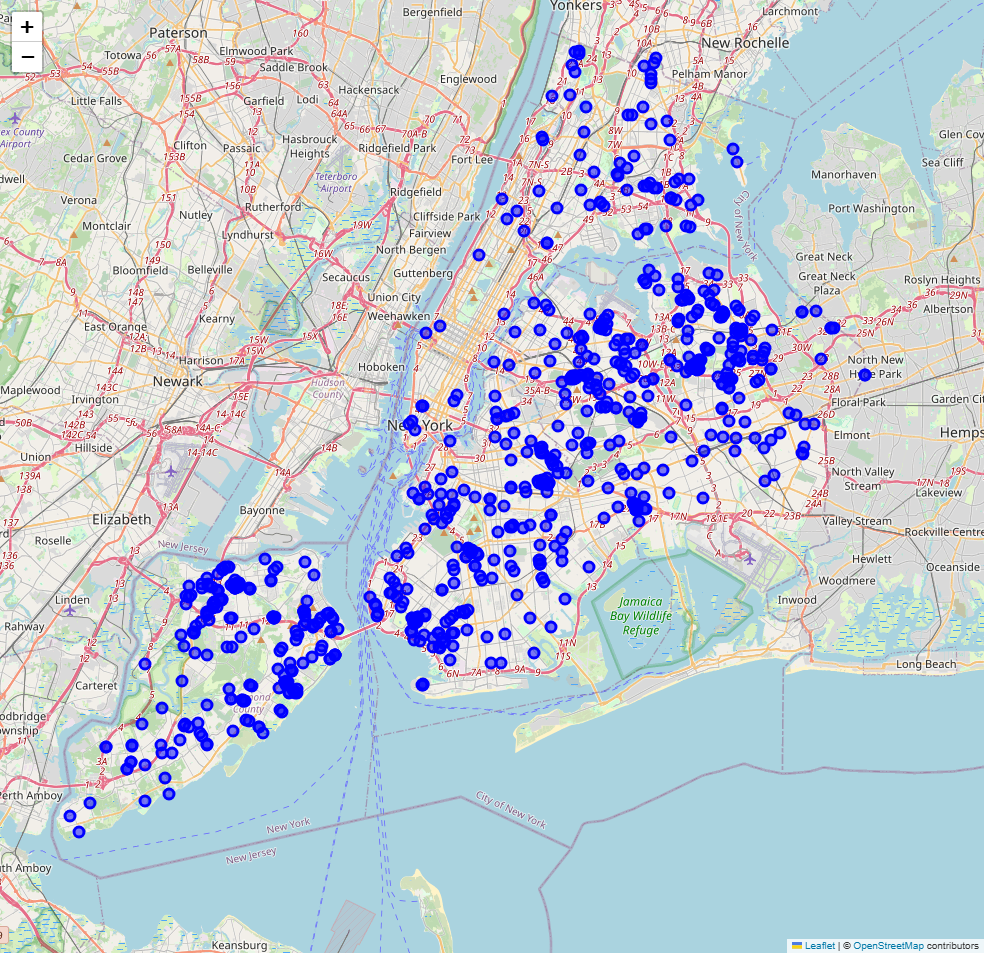

In [16]:
# Create the map around the mean of the latitude and longitude
m = folium.Map(location=[results_df['latitude'].mean(), results_df['longitude'].mean()])

# Loop through rows and add each point to the cluster
for _, row in results_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,               # Circle size
        color='blue',           # Border color
        fill=True,
        fill_color='blue',      # Fill color
        fill_opacity=0.5
    ).add_to(m)

# Display the map
point_map = "point_map.html"

options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

driver.set_window_size(1000, 1100)
driver.get("file://" + os.path.abspath("point_map.html"))
time.sleep(3)  # let map tiles load

driver.save_screenshot("pointmap_screenshot.png")
driver.quit()

from IPython.display import Image
Image("pointmap_screenshot.png")
